## Setting Up Your Python Environment

In [ ]:
# %%capture

# # Install additional dependencies
!pip install matplotlib pandas pillow torchtnt tqdm tabulate

# # Install package for creating visually distinct colormaps
!pip install distinctipy

# # Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

# # Install PyTorch with CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install imagecodecs to read .tif using skimage (https://blog.csdn.net/qq_40041133/article/details/109497863)
!pip install imagecodecs-lite
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 23.6 MB/s eta 0:00:00


## Importing the Required Dependencies

In [ ]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional
from skimage import io
import cv2

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# sort
import natsort

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, save_image
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [ ]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [ ]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

#### Explore dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/'
train_sample = file_path + 'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t002.tif'
mask_train_sample = file_path +'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg002.tif'

In [ ]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()
    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

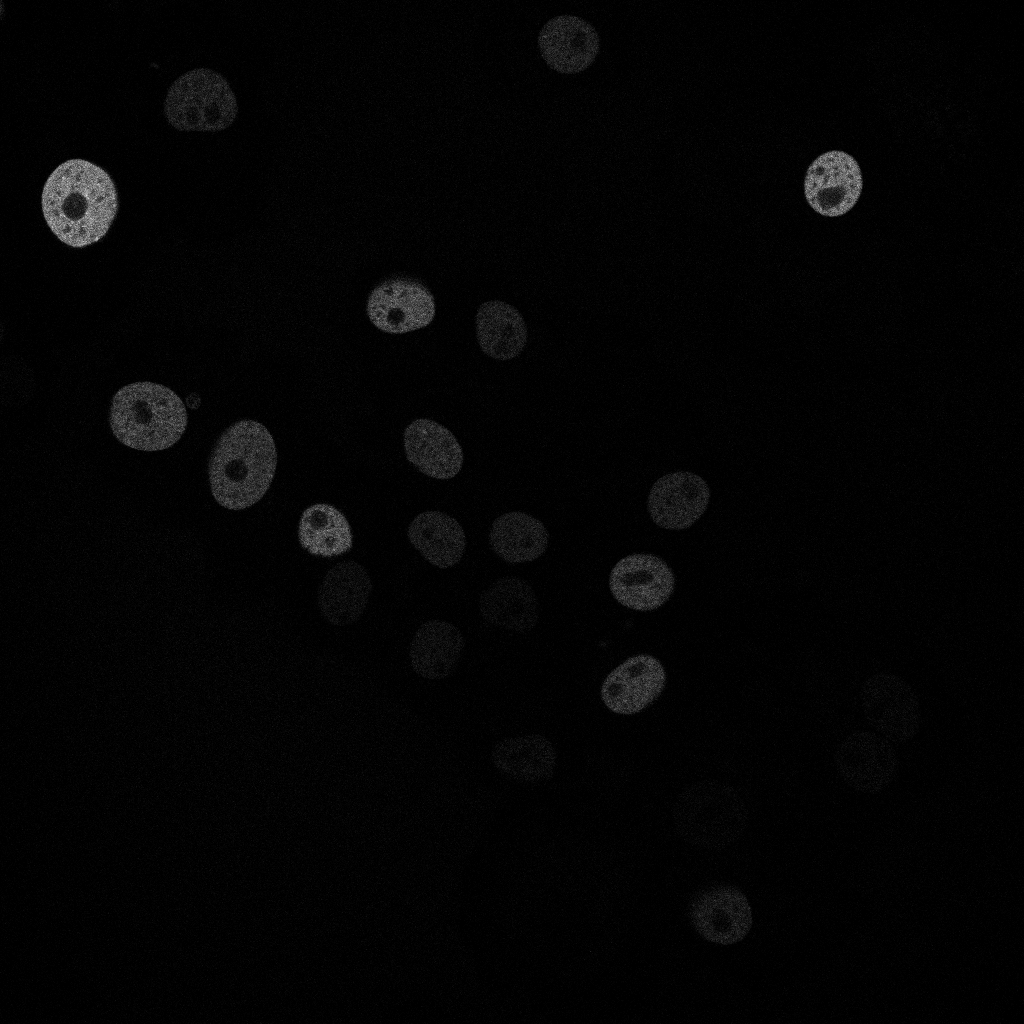

In [ ]:
image = io.imread(train_sample, plugin ='pil')
if image.dtype == "uint16":
    image = convert(image, 0, 255, np.uint8)
image = np.asarray(image)
# input_img = Image.fromarray(image)

# # clahe is a technique for increasing the visibility of a foggy image
# clahe = cv2.createCLAHE(clipLimit =2, tileGridSize=(8,8))
# cl_img = clahe.apply(image)

image = Image.fromarray(image)
img_shape = (image.height,image.width)

image = image.convert('RGB')
image

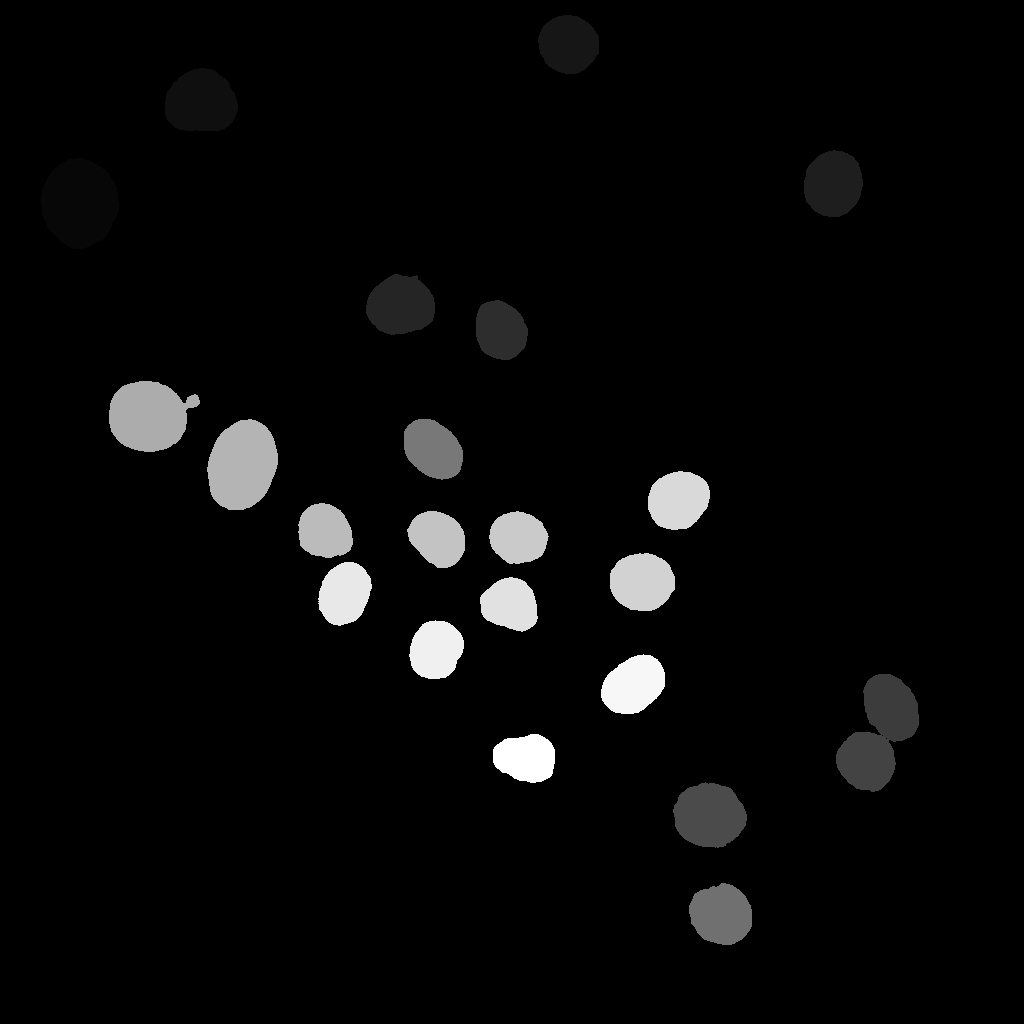

In [ ]:
mask = io.imread(mask_train_sample, plugin ='pil')
if mask.dtype == "uint16":
    mask = convert(mask, 0, 255, np.uint8)
mask = np.asarray(mask)

# input_img = Image.fromarray(image)

# # clahe is a technique for increasing the visibility of a foggy image
# clahe = cv2.createCLAHE(clipLimit =2, tileGridSize=(8,8))
# cl_img = clahe.apply(image)

mask = Image.fromarray(mask)
mask_shape = (mask.height,mask.width)

# mask = mask.convert('RGB')
mask

#### draw bounding box for each cell

torch.Size([23, 1024, 1024])
[ 41. 158. 118. 248.]


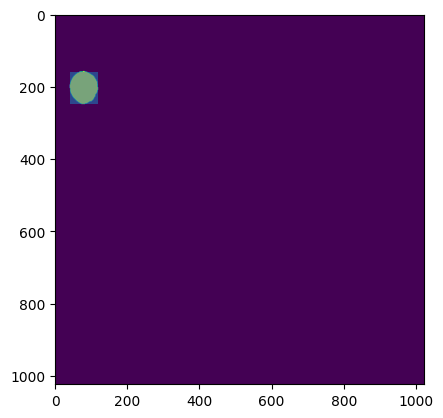

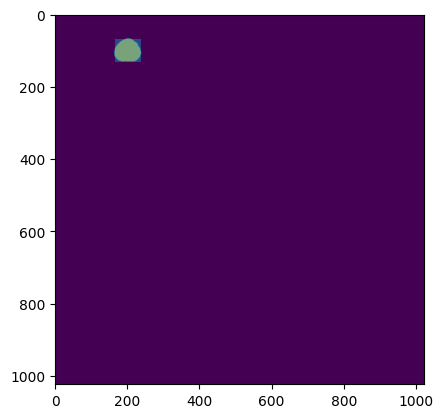

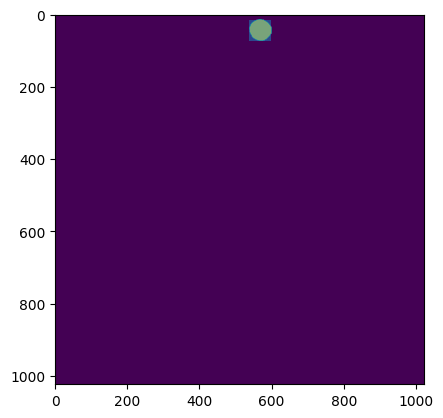

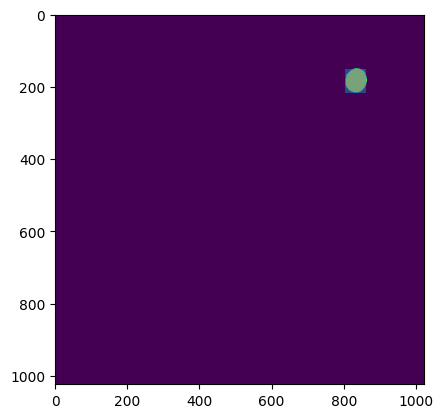

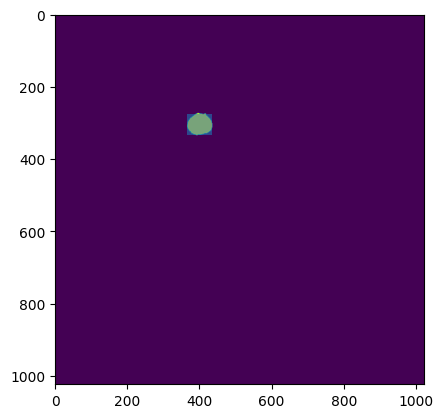

In [ ]:
mask_per_cell = []
mask = np.array(mask)
for cell in np.unique(mask):

    if cell == 0:   # skip background
        continue

    mask_per_cell.append(Image.fromarray(np.where(mask==cell, mask, 0)))

shape = mask_per_cell[0].size
masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_per_cell]))
print(masks.shape)
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=shape[::-1])
print(np.array(bboxes[0]))
bboxes_np = np.array(bboxes)

# show first 5 results
for i in range(len(mask_per_cell))[:5]:
    plt.figure()
    plt.gca().add_patch(Rectangle(xy=(bboxes_np[i][0], bboxes_np[i][1]), height=bboxes_np[i][3]-bboxes_np[i][1],
                                  width=bboxes_np[i][2]-bboxes_np[i][0], alpha=0.6))
    plt.imshow(mask_per_cell[i])

## Loading the Mask R-CNN Model

In [ ]:
class_names = ['background', 'cell']

# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:02<00:00, 83.8MB/s]


### Summarizing the Model

In [ ]:
test_inp = torch.randn(1, 3, 1024, 1024).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/usr/local/lib/python3.10/dist-packages/torchtnt/utils/module_summary.py:263: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs
0  MaskRCNN       45.9 M                 45.7 M        183 M         331 G

## Preparing the Data

### Training-Validation Split

In [ ]:
images_path = list(glob(file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/*.tif'))
print(images_path)

['/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t000.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t002.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t012.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t006.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t001.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t007.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t004.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t003.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t011.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/t015.tif', '/content/drive/MyDrive/Colab Notebooks/Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/0

In [ ]:
# Get the list of image path
images_path = list(glob(file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01/*.tif'))

# Shuffle the image IDs
random.shuffle(images_path)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(images_path)*train_pct)
val_split = int(len(images_path)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_images_path = images_path[:train_split]
val_images_path = images_path[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_images_path),
    "Validation Samples:": len(val_images_path)
}).to_frame().style.hide(axis='columns')

### Data Augmentation

#### Set training image size

In [ ]:
# Set training image size
train_sz = 1024

#### Initialize the transforms

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=1.0,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)

In [ ]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

In [ ]:
# draw bbox function
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font_size=25)

/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


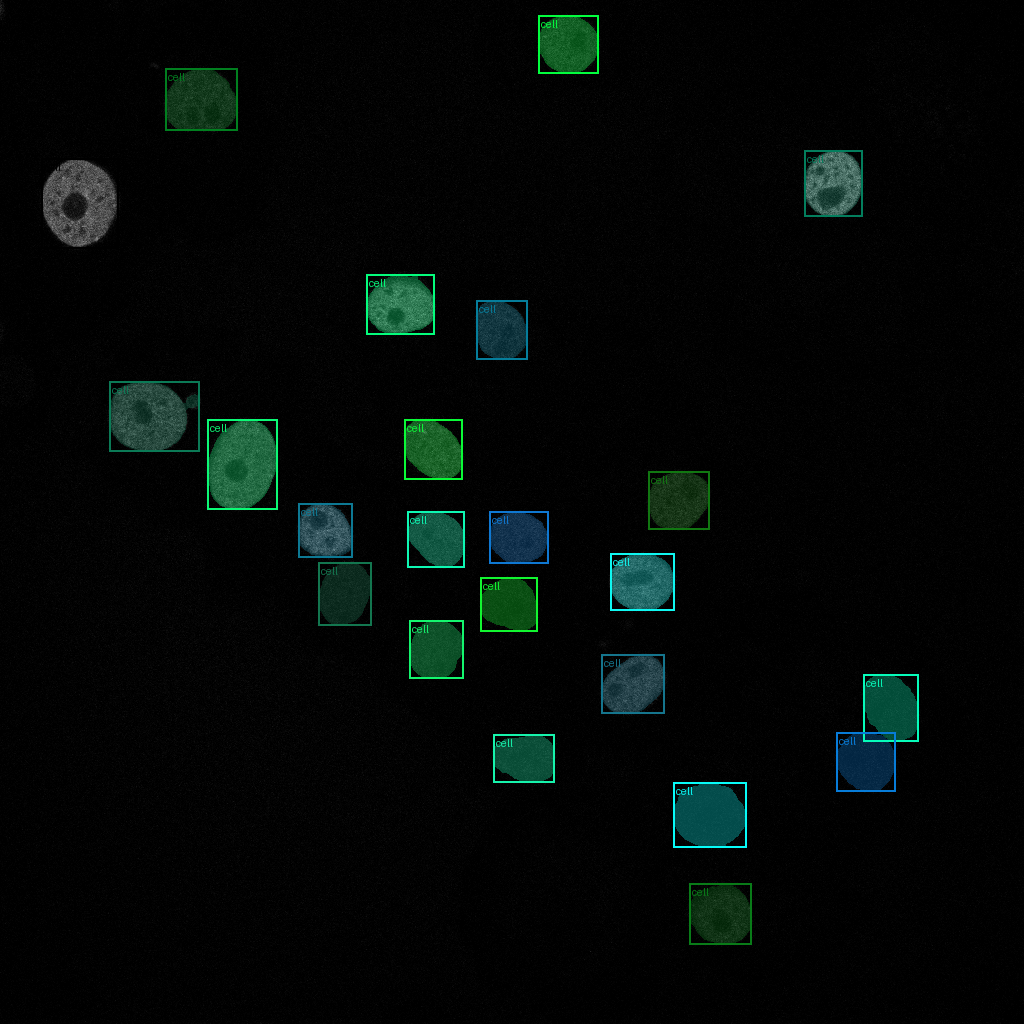

In [ ]:
mask_per_cell = []
mask = np.array(mask)
labels = []
for cell in np.unique(mask):

    if cell == 0:   # skip background
        continue

    mask_per_cell.append(Image.fromarray(np.where(mask==cell, mask, 0)))
    labels.append('cell')

shape = mask_per_cell[0].size
masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_per_cell]))
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=shape[::-1])

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks),
    'boxes': bboxes,
    'labels': torch.Tensor([1 for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(image, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']]
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

# summary
pd.Series({
    "Source Image:": image.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [ ]:
class CellDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms=None):
        super(Dataset, self).__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.transforms = transforms

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        current_image_path = self.images_path[index]
        current_mask_path = self.masks_path[index]

        image, target = self.load_img_and_target(current_image_path, current_mask_path)

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target # target include: mask, bbox, label

    def load_img_and_target(self, img_path, mask_path):
        image = io.imread(img_path, plugin ='pil')
        if image.dtype == "uint16":
            image = convert(image, 0, 255, np.uint8)
        image = Image.fromarray(image).convert('RGB')

        mask = io.imread(mask_path, plugin ='pil')
        if mask.dtype == "uint16":
            mask = convert(mask, 0, 255, np.uint8)

        mask_per_cell = []
        labels = []
        for cell in np.unique(mask):
            if cell == 0:   # skip background
                continue
            mask_per_cell.append(Image.fromarray(np.where(mask==cell, mask, 0)))
            labels.append(1)    # only segment cell
        labels = torch.Tensor(labels)
        labels = labels.to(dtype=torch.int64)

        shape = mask_per_cell[0].size
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_per_cell]))
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=shape[::-1])

        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}

### Image Transforms

In [ ]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [ ]:
train_masks_paths = [file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg'+ img_path.split('/')[-1][1:] for img_path in train_images_path]
val_masks_paths = [file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg'+ img_path.split('/')[-1][1:] for img_path in val_images_path]

# Instantiate the datasets using the defined transformations
train_dataset = CellDataset(train_images_path, train_masks_paths, train_tfms)
valid_dataset = CellDataset(val_images_path, val_masks_paths, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

### Inspect Samples

#### Inspect training set sample

In [ ]:
colors = distinctipy.get_colors(len(class_names))
int_colors = [tuple(int(c*255) for c in color) for color in colors]

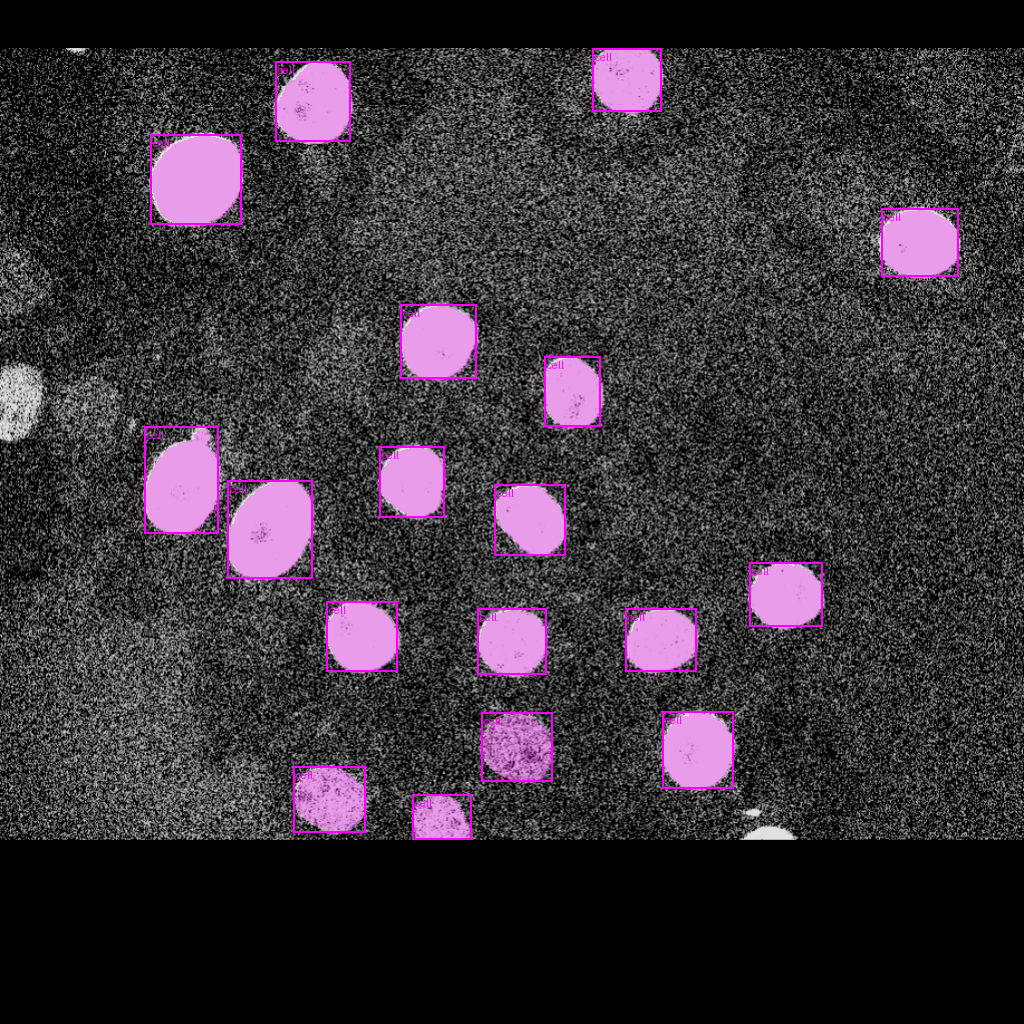

In [ ]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

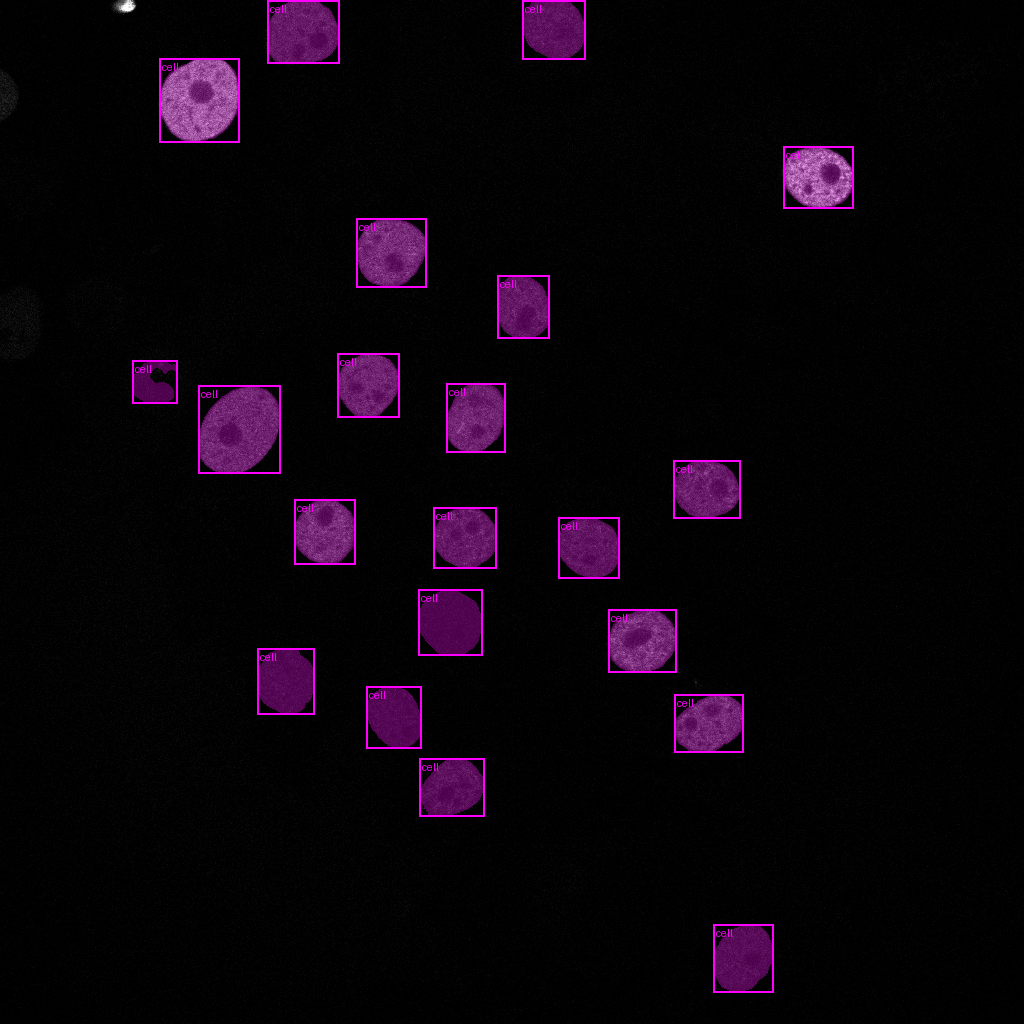

In [ ]:
dataset_sample = valid_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [ ]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': lambda batch: tuple(zip(*batch)),
    'pin_memory': True,
    'pin_memory_device': device
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

## Fine-tuning the Model

### Define the Training Loop

In [ ]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, is_training):
    """
    Function to run a single training or evaluation epoch.

    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.

    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()

    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar

    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item

        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If the loss is NaN or infinite, stop the training/evaluation process
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at batch {batch_id}. Stopping {'training' if is_training else 'evaluation'}.")
            break

    # Cleanup and close the progress bar
    progress_bar.close()

    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    """
    Main training loop.

    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device

    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

        # If the training or validation loss is NaN or infinite, stop the training process
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [ ]:
ckpoint = file_path+'checkpoints'

# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(ckpoint+"/"+f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

/content/drive/MyDrive/Colab Notebooks/checkpoints/2024-12-09_11-53-05/maskrcnn_resnet50_fpn_v2.pth


### Configure the Training Parameters

In [ ]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 30 #2

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

### Train the Model

In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

<ipython-input-27-63dba25691bc>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

## Making Predictions with the Model

### Preparing Input Data

In [ ]:
#load state dict
#cambiare cartella 'checkpoints/inserisci data e ora' per salvare in modo diverso
model.load_state_dict(torch.load(file_path+'checkpoints/2024-12-09_11-53-05/maskrcnn_resnet50_fpn_v2.pth'))
model.eval()

<ipython-input-31-a5e3d830a105>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path+'checkpoints/2024-12-09_11-53-05/maskrcnn_resnet5

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

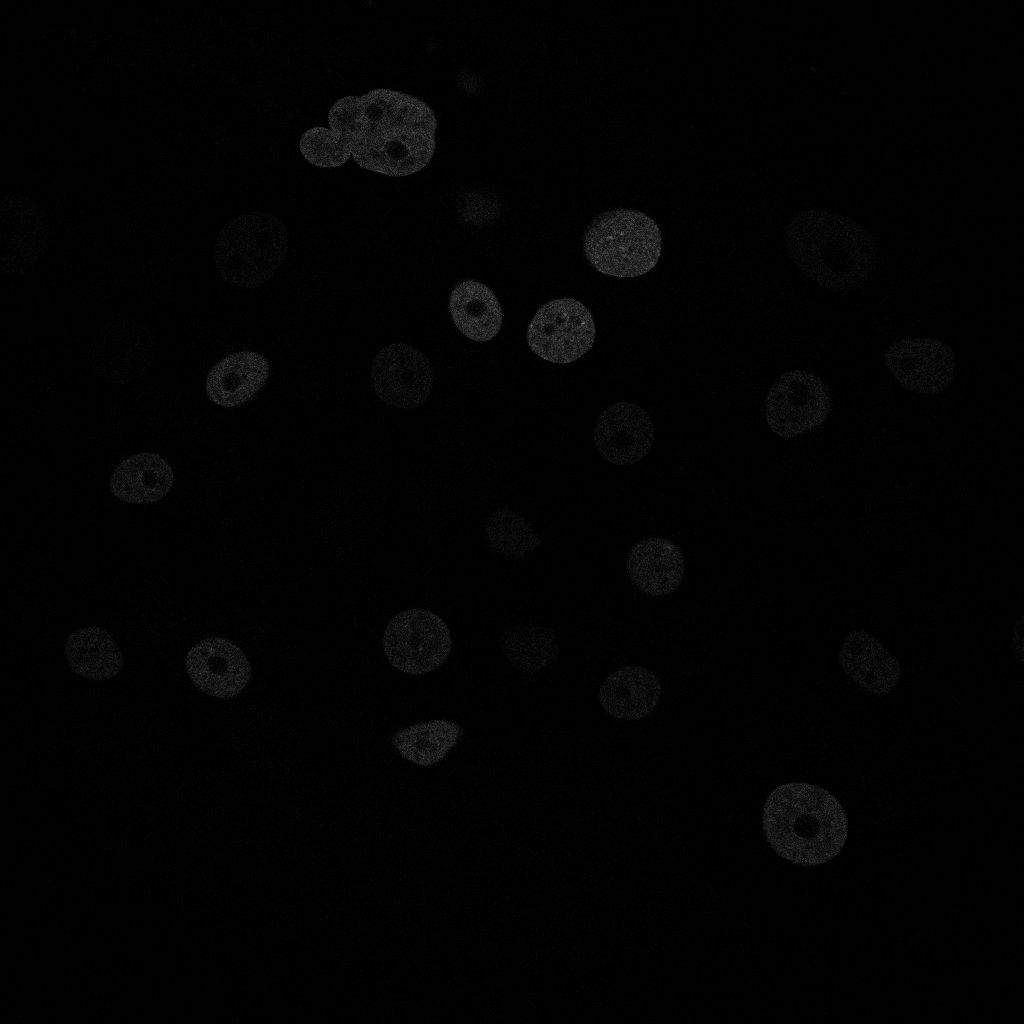

In [ ]:
# # Choose a random item from the validation set
#file_id = random.choice(glob('Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/02/*.tif'))

# Open the test file

#t072.tif => 2epochs - 30epochs
#t030.tif => 2_2epochs - 2_30epochs
#t022.tif => 3_2epochs - 3_30epochs
test_img = Image.open(file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/02/t022.tif').convert('RGB')


# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

#### Get the target annotation data

In [ ]:
mask_path = file_path+'Fluo-N2DH-GOWT1/train/Fluo-N2DH-GOWT1/02_GT/SEG/man_seg022.tif'
mask = io.imread(mask_path, plugin= 'pil')
if mask.dtype == "uint16":
    mask = convert(mask, 0, 255, np.uint8)

mask_per_cell = []
target_labels = []
mask = np.array(mask)
for cell in np.unique(mask):
    if cell == 0:   # skip background
        continue
    mask_per_cell.append(Image.fromarray(np.where(mask==cell, mask, 0)))
    target_labels.append('cell')

shape = mask_per_cell[0].size
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_per_cell]))

target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=shape[::-1])

#### Pass the input data to the model

In [ ]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

#### Filter the model output

In [ ]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

#### Annotate the image using the model predictions

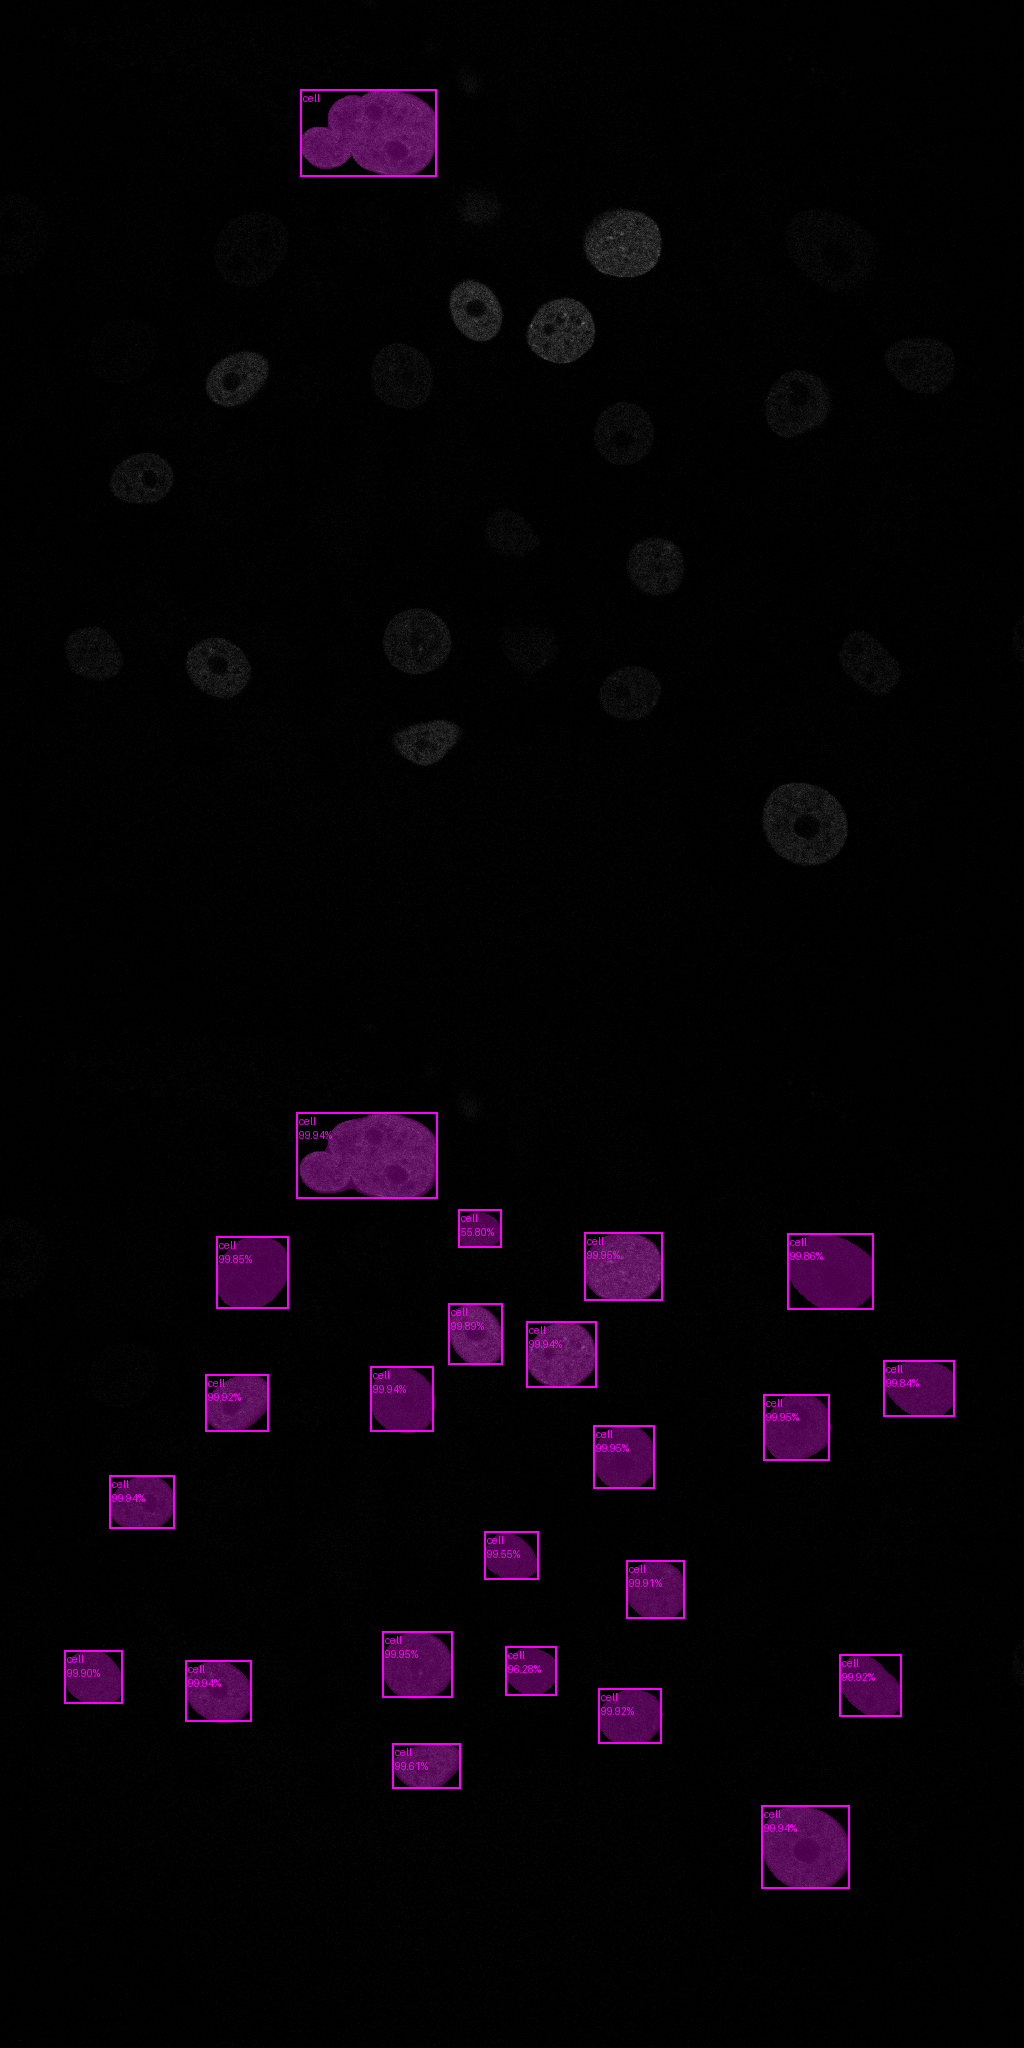

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Funzione per allineare le liste alla stessa lunghezza
def align_lists(*lists, fill_value=""):
    max_length = max(len(lst) for lst in lists)
    return [lst + [fill_value] * (max_length - len(lst)) for lst in lists]

# Get the annotation colors for the targets and predictions
target_colors = [int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors = [int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
annotated_tensor_target = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
annotated_tensor_target = draw_bboxes(image=annotated_tensor_target, boxes=target_bboxes, labels=target_labels, colors=target_colors)

# Annotate the test image with the predicted segmentation masks
annotated_tensor_pred = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
annotated_tensor_pred = draw_bboxes(
    image=annotated_tensor_pred,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Save annotated images
save_image(annotated_tensor_target / 255, "target_annotations.png")
save_image(annotated_tensor_pred / 255, "predicted_annotations.png")

# Preparare i dati per il DataFrame
target_labels_padded, target_bboxes_padded, pred_labels_padded, pred_bboxes_padded, pred_scores_padded = align_lists(
    target_labels,
    list(np.round(target_bboxes.numpy(), decimals=3)),
    pred_labels,
    list(np.round(pred_bboxes.numpy(), decimals=3)),
    pred_scores.tolist()
)

# Creare il DataFrame
data = {
    "Target Labels": target_labels_padded,
    "Target BBoxes": target_bboxes_padded,
    "Predicted Labels": pred_labels_padded,
    "Predicted BBoxes": pred_bboxes_padded,
    "Confidence Scores": [f"{prob*100:.2f}%" if isinstance(prob, (int, float)) else "" for prob in pred_scores_padded]
}
results_df = pd.DataFrame(data)

# Salvare il DataFrame in un file CSV
results_df.to_csv("results.csv", index=False)

# Visualizzare le immagini annotate affiancate
display(stack_imgs([tensor_to_pil(annotated_tensor_target), tensor_to_pil(annotated_tensor_pred)]))

# Opzionale: Scaricare i file in Colab
from google.colab import files
files.download("target_annotations.png")
files.download("predicted_annotations.png")
files.download("results.csv")

